# 投球分類モデル（Hybrid Weighted Ensemble）
**作成日**: 2026/01/13
**目的**: Baseline (Ensemble) の高精度を維持しつつ、FC vs SL の誤分類を軽減する。
**手法**: シングルモデル構成（RF + XGB + LGBM）において、**FC（Cutter）の誤分類に対するペナルティ（重み）を2倍** に設定して学習を行う。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'sans-serif'


In [2]:
# データの読み込みと特徴量作成
df = pd.read_csv('train_with_features.csv')

# === Feature Engineering (Phase 1 & 2 Features) ===
df['velocity_times_pfx_z'] = df['release_speed'] * df['pfx_z']
df['spin_per_mph'] = df['release_spin_rate'] / df['release_speed']
df['horizontal_vertical_ratio'] = df['pfx_x'] / (df['pfx_z'].abs() + 0.1)
df['speed_spin_ratio'] = df['release_speed'] / (df['release_spin_rate'] + 1)

features = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z', 'movement_magnitude', 
    'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis',
    'speed_spin_ratio', 'horizontal_vertical_ratio',
    'spin_efficiency', 'abs_horizontal_movement', 'movement_angle'
]
# Ensure features exist
existing_features = [f for f in features if f in df.columns]
target = 'pitch_type'

df_clean = df.dropna(subset=existing_features + [target]).copy()
print(f"Clean data shape: {df_clean.shape}")
print(f"Features used: {existing_features}")


Clean data shape: (495454, 22)
Features used: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'movement_magnitude', 'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis', 'speed_spin_ratio', 'horizontal_vertical_ratio', 'spin_efficiency', 'abs_horizontal_movement', 'movement_angle']


In [3]:
# データ分割
le = LabelEncoder()
y = le.fit_transform(df_clean[target])
X = df_clean[existing_features]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 重み付け (Sample Weighting) ===
# 1. まず基本のバランス重みを計算
weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 2. FC (Cutter) の重みを少し増やす (1.3倍 - Mild Penalty)
# 2.0倍だとAccuracyが0.83まで低下したため緩和
fc_idx = le.transform(['FC'])[0]
weights = np.where(y_train == fc_idx, weights * 1.3, weights)

print("Sample Weights Created. FC Check:")
print(f"Mean Weight (Overall): {weights.mean():.4f}")
print(f"Mean Weight (FC): {weights[y_train == fc_idx].mean():.4f}")
print(f"Mean Weight (Others): {weights[y_train != fc_idx].mean():.4f}")


Sample Weights Created. FC Check:
Mean Weight (Overall): 1.0200
Mean Weight (FC): 1.0957
Mean Weight (Others): 1.0135


In [4]:
# モデル学習 (Single Models with Weights)

# 1. XGBoost
print("Training XGBoost...")
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)
model_xgb.fit(X_train, y_train, sample_weight=weights)
xgb_acc = accuracy_score(y_valid, model_xgb.predict(X_valid))
print(f"XGB Accuracy: {xgb_acc:.4f}")

# 2. LightGBM
print("Training LightGBM...")
model_lgbm = lgbm.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
model_lgbm.fit(X_train, y_train, sample_weight=weights)
lgbm_acc = accuracy_score(y_valid, model_lgbm.predict(X_valid))
print(f"LGBM Accuracy: {lgbm_acc:.4f}")

# 3. Random Forest (RF doesn't take sample_weight in fit generally in the same way for boosting, 
# or can use class_weight='balanced_subsample'. But sklearn fit() does take sample_weight)
print("Training Random Forest...")
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)
# RFにも重みを適用
model_rf.fit(X_train, y_train, sample_weight=weights)
rf_acc = accuracy_score(y_valid, model_rf.predict(X_valid))
print(f"RF Accuracy: {rf_acc:.4f}")


Training XGBoost...


XGB Accuracy: 0.8358
Training LightGBM...


LGBM Accuracy: 0.8535
Training Random Forest...


RF Accuracy: 0.8137


In [5]:
# === Ensemble (Soft Voting) ===
# すでに学習済みのモデルを使って手動でSoft Votingを行う
# (sklearnのVotingClassifierはfit時にsample_weightを渡すのが面倒な場合があるため)

print("Ensembling...")

# 各モデルの確率予測を取得
p_xgb = model_xgb.predict_proba(X_valid)
p_lgbm = model_lgbm.predict_proba(X_valid)
p_rf = model_rf.predict_proba(X_valid)

# 平均 (Simple Average)
p_ensemble = (p_xgb + p_lgbm + p_rf) / 3.0

# 最終予測
y_pred_ensemble = np.argmax(p_ensemble, axis=1)
pred_labels = le.inverse_transform(y_pred_ensemble)
true_labels = le.inverse_transform(y_valid)

acc_ensemble = accuracy_score(y_valid, y_pred_ensemble)
print(f"Weighted Ensemble Accuracy: {acc_ensemble:.4f}")


Ensembling...


Weighted Ensemble Accuracy: 0.8439


              precision    recall  f1-score   support

          CH       0.91      0.85      0.88     10764
          CU       0.87      0.76      0.81      6568
          EP       0.85      0.88      0.87        78
          FA       0.68      0.87      0.76       156
          FC       0.61      0.86      0.71      7838
          FF       0.97      0.92      0.94     31826
          FO       0.59      0.90      0.71       107
          FS       0.60      0.86      0.71      2221
          KC       0.56      0.85      0.68      2058
          KN       0.96      0.96      0.96        27
      Others       0.65      0.58      0.61        26
          SI       0.91      0.91      0.91     15316
          SL       0.87      0.63      0.73     15924
          ST       0.69      0.87      0.77      5789
          SV       0.36      0.90      0.52       393

    accuracy                           0.84     99091
   macro avg       0.74      0.84      0.77     99091
weighted avg       0.87   

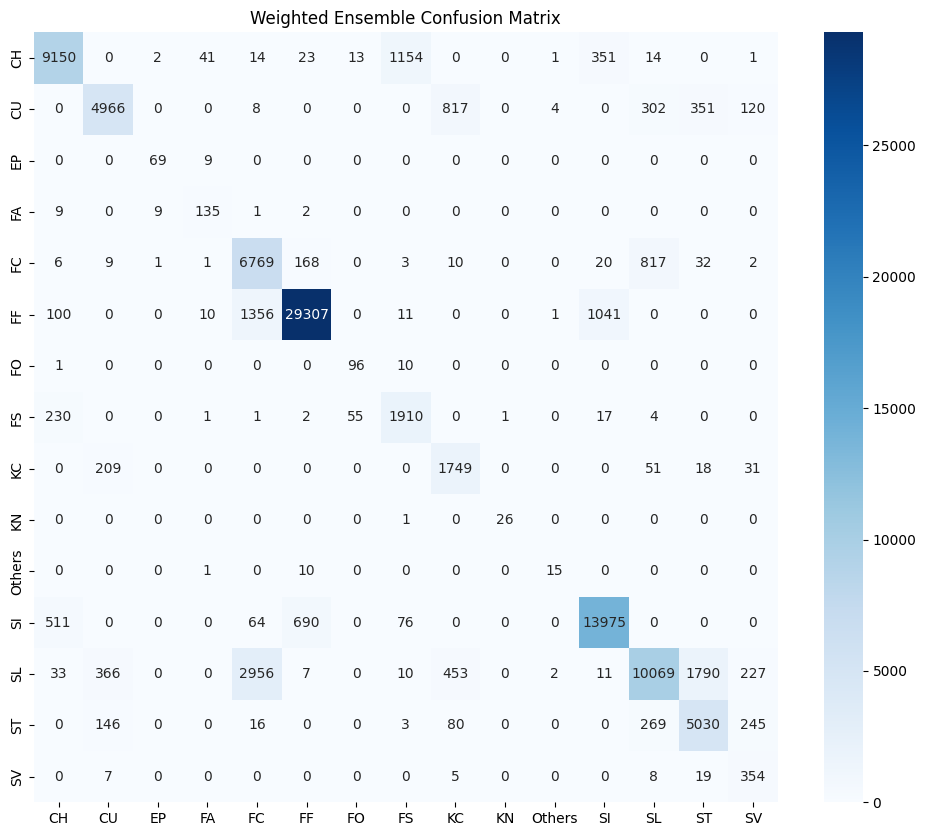

In [6]:
# === Evaluation ===
print(classification_report(y_valid, y_pred_ensemble, target_names=le.classes_))

# FC Analysis
print("\n=== FC Report ===")
print(classification_report(y_valid, y_pred_ensemble, target_names=le.classes_, labels=[le.transform(['FC'])[0]]))

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Weighted Ensemble Confusion Matrix')
plt.show()
